# 라이브러리 및 Geometric 설정

In [4]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

# 모델 라이브러리
from src.model.cmaqnet_cond_unet import build_model

# 학습 및 처리/분석 관련 라이브러리
import numpy as np
import pandas as pd
import netCDF4 as nc
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Geometric 및 시각화 라이브러리
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

# Training (Nitrate)

In [ ]:
# 입력 데이터셋 로드
# emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_05 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_nitrate.csv')
# emis_ctrl_2019_05['Timestep'] = 0.0 # 추후에 Boundary/Time Embedding 동시 수행 관점에서 사용
emis_ctrl_2019_05['Boundary'] = 0.5
emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([
    emis_ctrl_2019_05,
    emis_ctrl_2019_10
], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# 레이블 데이터 로드
base_path_2019 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2019'
conc_path = []
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '0.50', f'ACONC.{i}'))
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))
conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [ ]:
# 모델 학습 시 저장 경로
model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/nitrate_prediction/final_model_v2'

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 32  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed, stratify=boundary_data)

# Cosine Decay 스케줄 설정
steps_per_epoch = len(X_emis_train) // batch_size 
total_steps = epochs * steps_per_epoch

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,
        decay_steps=total_steps,
        alpha=0.1  # 최종 lr 비율 (0이면 최솟값이 0)
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[128],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=4,
        in_filters=20,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.Huber(delta=1)  # delta는 Huber 손실 전환점
    )

early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = model.fit(
    x=[X_emis_train, X_boundary_train],
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test],
    callbacks=[early_stop]
)

model.save(model_path)

In [ ]:
def plot_loss(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # 1. 전체 에포크에 대한 학습 및 검증 손실
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. 마지막 10 에포크의 손실 (세부 분석)
    plt.subplot(2, 2, 2)
    if len(epochs) >= 30:
        last_epochs = epochs[-30:]
        plt.plot(last_epochs, history.history['loss'][-30:], label='Training Loss', color='blue')
        plt.plot(last_epochs, history.history['val_loss'][-30:], label='Validation Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss (Last 10 Epochs)')
        plt.legend()
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, "Not enough epochs for zoomed plot", ha='center')
    
    # 3. 학습 손실과 검증 손실의 차이
    plt.subplot(2, 2, 3)
    loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
    plt.plot(epochs, loss_diff, label='Val Loss - Train Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Difference')
    plt.title('Difference between Validation and Training Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 4. 이동 평균 (window=10)을 통한 평활화된 손실 추세
    plt.subplot(2, 2, 4)
    window = 10
    if len(epochs) >= window:
        train_ma = [np.mean(history.history['loss'][max(0, i-window):i]) for i in range(1, len(history.history['loss'])+1)]
        val_ma = [np.mean(history.history['val_loss'][max(0, i-window):i]) for i in range(1, len(history.history['val_loss'])+1)]
        plt.plot(epochs, train_ma, label='Training Loss MA', color='blue', linestyle='--')
        plt.plot(epochs, val_ma, label='Validation Loss MA', color='orange', linestyle='--')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Moving Average)')
        plt.title('Moving Average of Loss (window = 10)')
        plt.legend()
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, "Not enough epochs for moving average plot", ha='center')
    
    plt.tight_layout()
    plt.show()

# Loss 결과물 출력
plot_loss(history)

# Prediction

In [5]:
test_split = 0.2  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/nitrate_prediction/final_model_v2')

# 입력 데이터셋 로드
# emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_05 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_nitrate.csv')
# emis_ctrl_2019_05['Timestep'] = 0.0 # 추후에 Boundary/Time Embedding 동시 수행 관점에서 사용
emis_ctrl_2019_05['Boundary'] = 0.5
emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([
    emis_ctrl_2019_05,
    emis_ctrl_2019_10
], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# 레이블 데이터 로드
base_path_2019 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2019'
conc_path = []
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '0.50', f'ACONC.{i}'))
for i in range(1, 120): conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))
conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed, stratify=pred_boundary_data)

y_preds = model.predict([X_emis_test,  X_boundary_test])
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
2/2 [==============================] - 3s 400ms/step


In [6]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)
pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용

In [7]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=100, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    # y_err_std = np.std(y_norm_err, axis=1)  # (48,)
    return y_err_mean, y_err_std

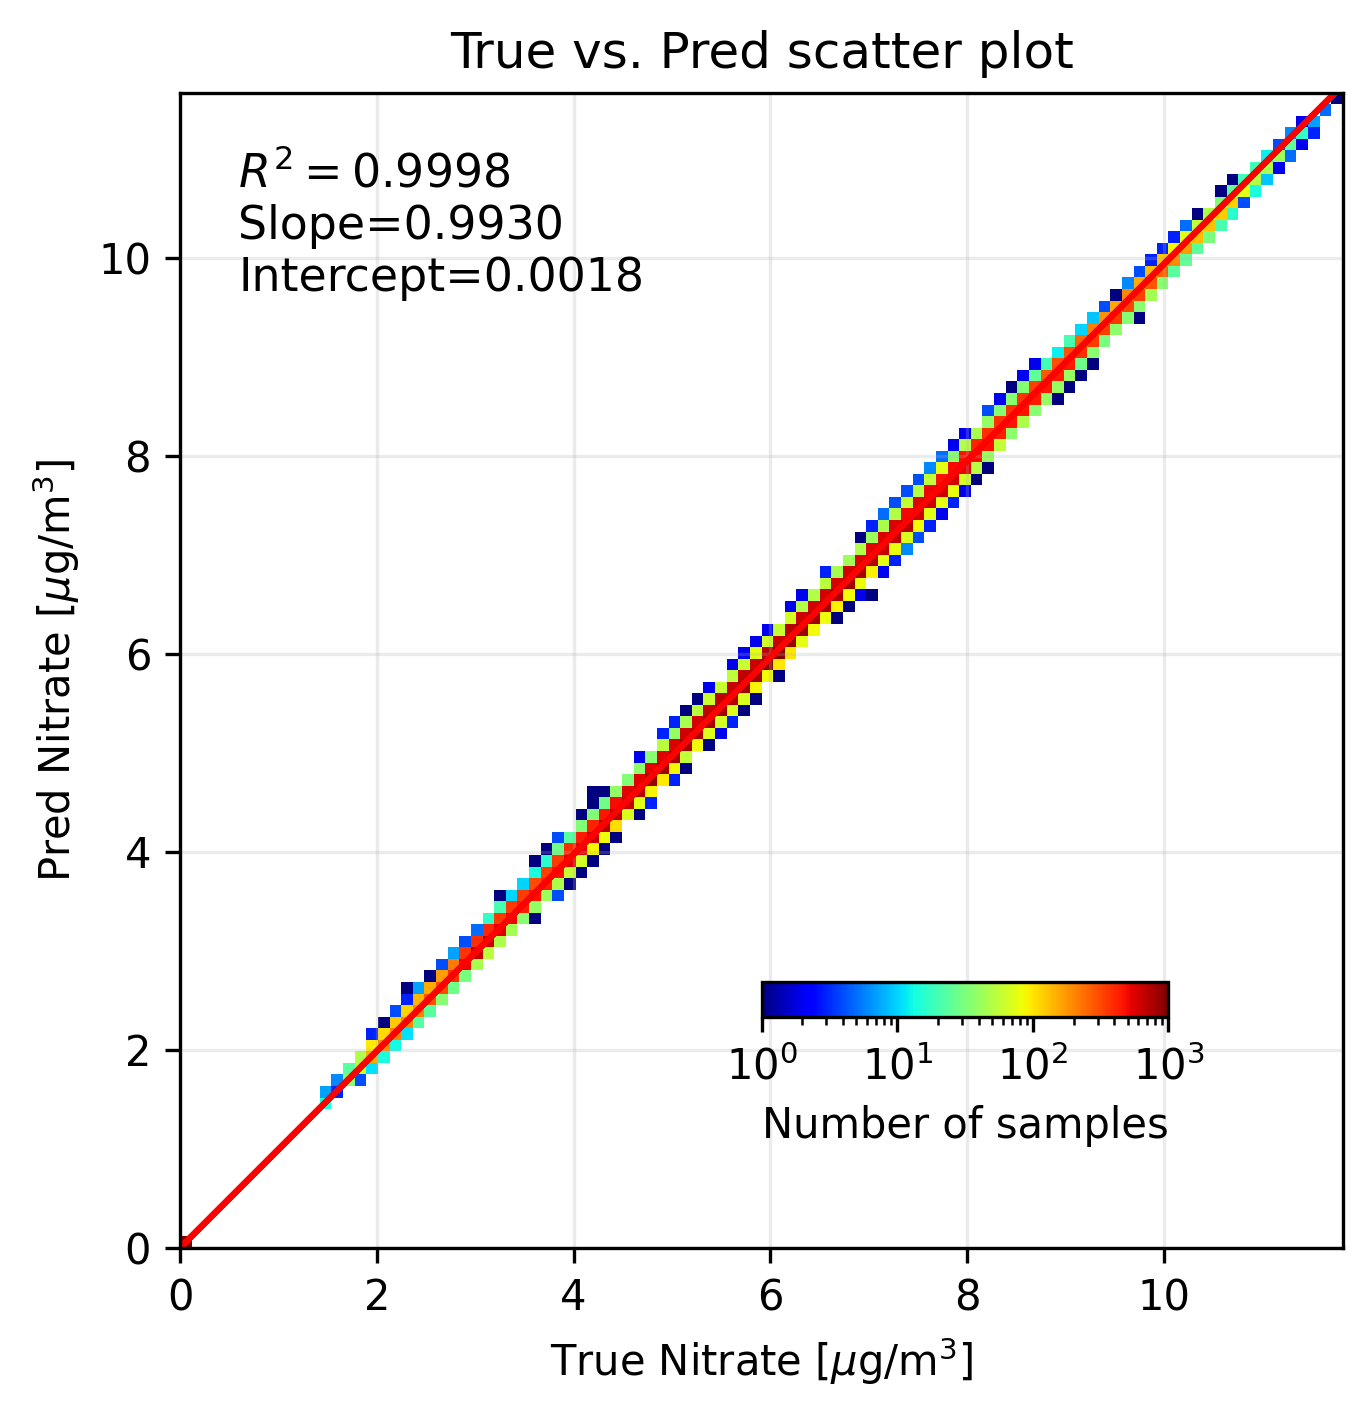

In [8]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

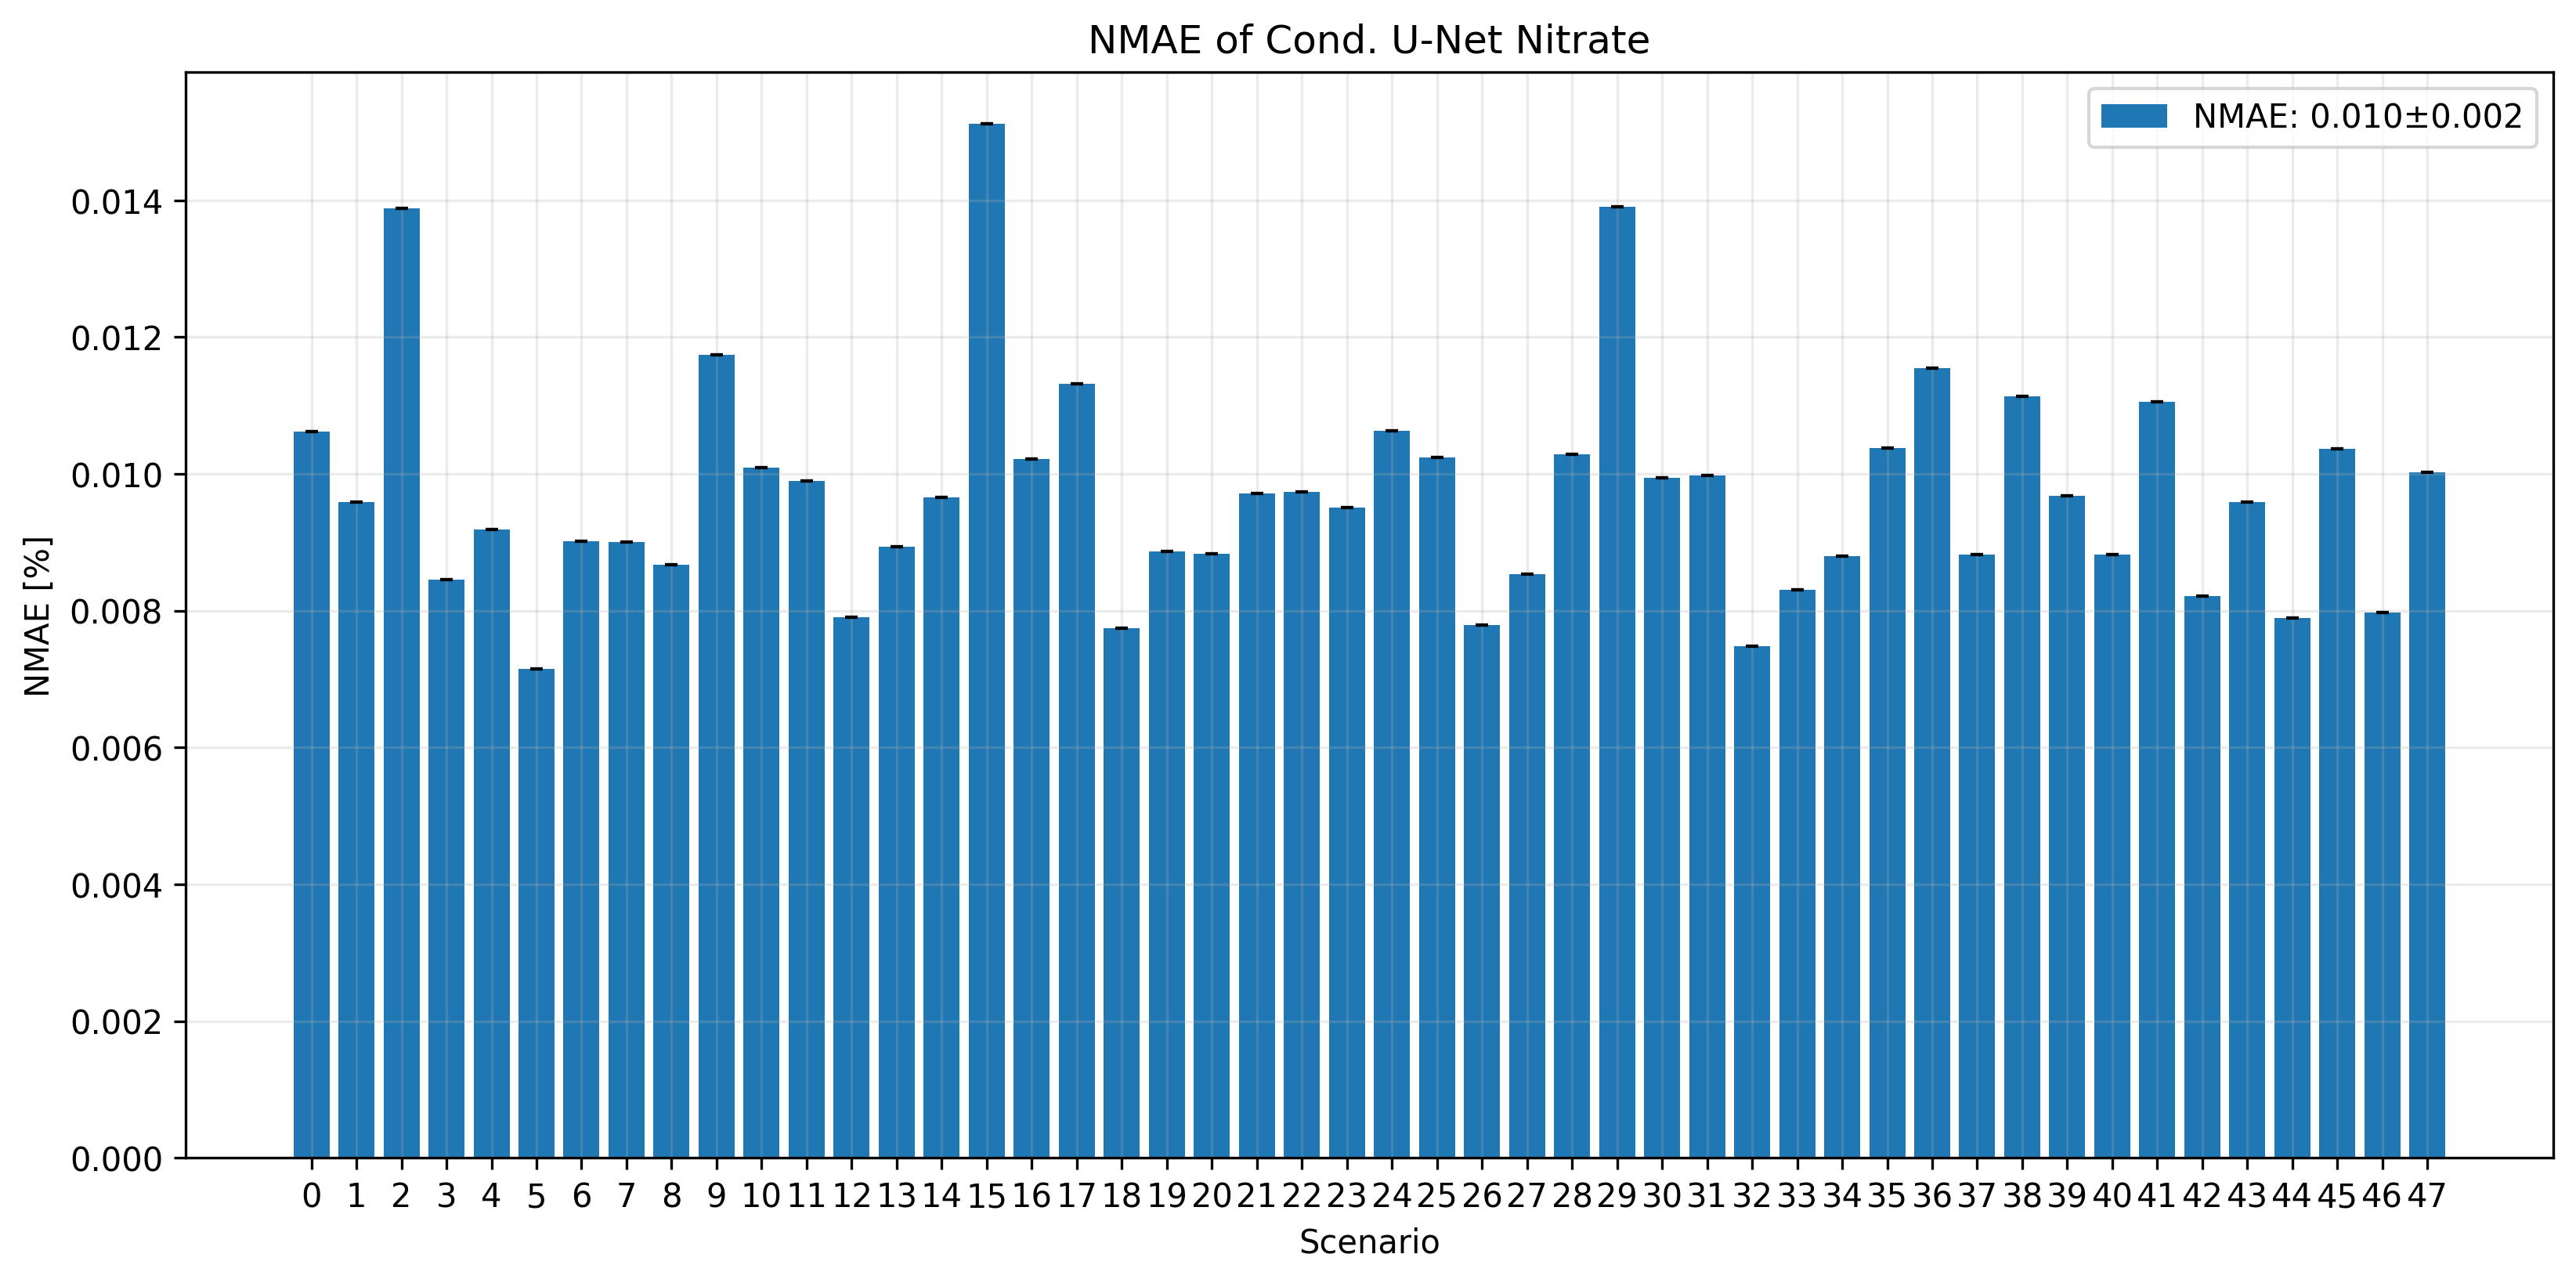

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

max: 15
min: 5


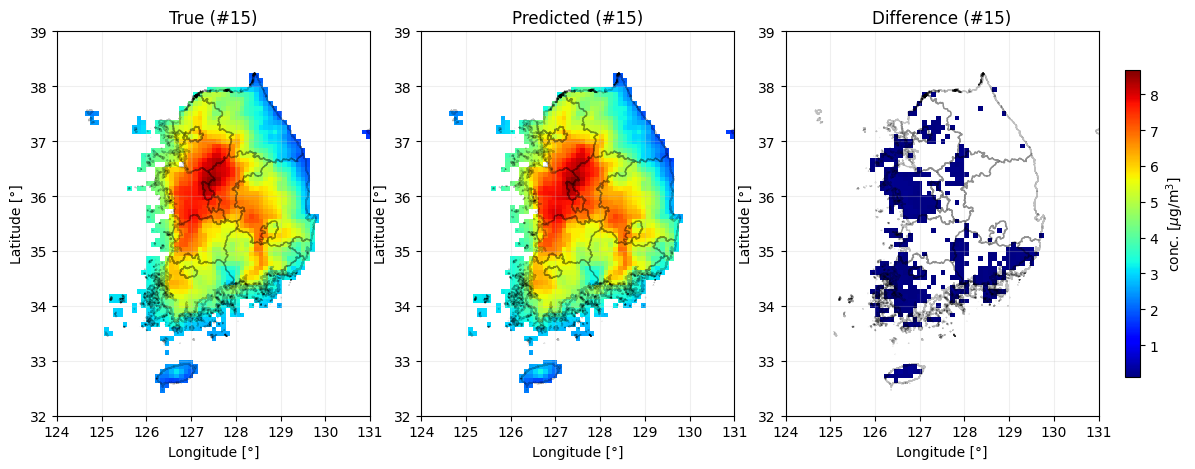

In [10]:
cmap_with_white = plt.get_cmap('jet').copy()   # jet 컬러맵 복사
cmap_with_white.set_bad('white')               # 마스킹된 부분을 흰색으로

def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = [index]
    
    local_min = min(y_true[indices].min(), y_pred[indices].min())
    local_max = max(y_true[indices].max(), y_pred[indices].max())
    local_diff = np.abs(y_true[indices] - y_pred[indices])
    local_max = max(local_max, local_diff.max())

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]  # (1, 3) 형태로 맞춤

    # 지도 투영 좌표 범위
    x_min = -180000 + offset_x
    x_max =  414000 + offset_x
    y_min = -585000 + offset_y
    y_max =  144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]

    # threshold 이하이면 흰색으로 표시
    threshold = 0.1

    for i, idx in enumerate(indices):
        
        # (A) True
        data_true = y_true[idx][::-1]
        masked_true = np.ma.masked_where(data_true <= threshold, data_true)
        im_true = axes[i, 0].imshow(
            masked_true,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max 
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_xlim(x_min, x_max)
        axes[i, 0].set_ylim(y_min, y_max)
        axes[i, 0].set_xticks(x_ticks)
        axes[i, 0].set_yticks(y_ticks)
        axes[i, 0].set_xticklabels(x_labels)
        axes[i, 0].set_yticklabels(y_labels)
        axes[i, 0].grid(alpha=0.25, color='silver')

        # (B) Predicted
        data_pred = y_pred[idx][::-1]
        masked_pred = np.ma.masked_where(data_pred <= threshold, data_pred)

        im_pred = axes[i, 1].imshow(
            masked_pred,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_xlim(x_min, x_max)
        axes[i, 1].set_ylim(y_min, y_max)
        axes[i, 1].set_xticks(x_ticks)
        axes[i, 1].set_yticks(y_ticks)
        axes[i, 1].set_xticklabels(x_labels)
        axes[i, 1].set_yticklabels(y_labels)
        axes[i, 1].grid(alpha=0.25, color='silver')

        # (C) Difference
        data_diff = np.abs(y_true[idx] - y_pred[idx])[::-1]
        masked_diff = np.ma.masked_where(data_diff <= threshold, data_diff)

        im_diff = axes[i, 2].imshow(
            masked_diff,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_xlim(x_min, x_max)
        axes[i, 2].set_ylim(y_min, y_max)
        axes[i, 2].set_xticks(x_ticks)
        axes[i, 2].set_yticks(y_ticks)
        axes[i, 2].set_xticklabels(x_labels)
        axes[i, 2].set_yticklabels(y_labels)
        axes[i, 2].grid(alpha=0.25, color='silver')

    # 서브플롯 간격/레이아웃 조정
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.tight_layout(rect=[0, 0, 0.88, 0.96])

    cbar = fig.colorbar(
        im_true,
        ax=axes.ravel().tolist(),
        orientation='vertical',
        fraction=0.03,
        pad=0.02,
        shrink=0.8
    )
    cbar.set_label('conc. [$\\mu \\mathrm{g}/\\mathrm{m}^3$]')

    plt.show()

# ==============================
print("max:",np.argmax(score))
print("min:",np.argmin(score))
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=np.argmax(score))

# 기타 분석 내용

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

# ----------------------------------------
# 1. 기본 지표 계산 함수 (예: NSE, d, Spearman, MBE, FB 등)
# ----------------------------------------
def nash_sutcliffe_efficiency(y_true, y_pred):
    """
    Nash–Sutcliffe Efficiency (NSE)
    hydrological model 평가에 자주 사용되는 지표
    """
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - np.mean(y_true))**2)
    return 1 - numerator / denominator

def willmott_d(y_true, y_pred):
    """
    Willmott's d
    관측값과 예측값의 편차를 표준화하는 방식
    """
    obs_mean = np.mean(y_true)
    numerator = np.sum((y_pred - y_true)**2)
    denominator = np.sum((np.abs(y_pred - obs_mean) + np.abs(y_true - obs_mean))**2)
    return 1 - (numerator / denominator)

def spearman_corr(y_true, y_pred):
    """
    스피어만 상관계수
    비선형 관계에서도 순위 정보를 반영하여 상관성 측정
    """
    rho, pval = st.spearmanr(y_true, y_pred)
    return rho, pval

def mean_bias_error(y_true, y_pred):
    """ MBE (Mean Bias Error) """
    return np.mean(y_pred - y_true)

def fractional_bias(y_true, y_pred):
    """
    Fractional Bias (화학농도 예측에서 자주 쓰이는 지표 중 하나)
    """
    return 2.0 * np.mean(y_pred - y_true) / np.mean(y_pred + y_true)


# ----------------------------------------
# 2. 잔차 분석 및 시각화
# ----------------------------------------
def plot_residuals(y_true, y_pred):
    """
    Residual vs. True, Residual vs. Pred, 그리고 Q-Q plot을 그려서
    잔차의 분포/정규성/극단값 구간 등을 시각적으로 확인
    """
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # (1) Residual vs. True
    axes[0].scatter(y_true, residuals, color='blue', alpha=0.7, edgecolors='none')
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_xlabel('True Nitrate [µg/m³]')
    axes[0].set_ylabel('Residual (Pred - True)')
    axes[0].set_title('Residual vs. True Nitrate')

    # (2) Residual vs. Pred
    axes[1].scatter(y_pred, residuals, color='orange', alpha=0.7, edgecolors='none')
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_xlabel('Pred Nitrate [µg/m³]')
    axes[1].set_ylabel('Residual (Pred - True)')
    axes[1].set_title('Residual vs. Pred Nitrate')

    # (3) Q-Q plot
    sm.qqplot(residuals, line='45', ax=axes[2], markersize=3, color='blue')
    axes[2].set_title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.show()


# ----------------------------------------
# 3. 고농도 구간(예: 0.03 µg/m³ 초과)만 별도 분석
# ----------------------------------------
def analyze_high_concentration(y_true, y_pred, threshold=0.03):
    """
    예: y_true가 0.03 µg/m³ 이상인 부분만 추려서
        NSE, d, Spearman, etc. 재계산
    """
    mask = (y_true > threshold)
    if np.sum(mask) < 2:
        print(f"[High nitrate > {threshold:.3f}] 샘플이 충분치 않습니다.")
        return

    y_true_high = y_true[mask]
    y_pred_high = y_pred[mask]

    nse_val = nash_sutcliffe_efficiency(y_true_high, y_pred_high)
    d_val   = willmott_d(y_true_high, y_pred_high)
    rho, pval = spearman_corr(y_true_high, y_pred_high)

    print(f"[High nitrate > {threshold:.3f}]")
    print(f"  NSE = {nse_val:.4f}")
    print(f"  d   = {d_val:.4f}")
    print(f"  Spearman = {rho:.4f}, p-value = {pval:.1e}")


# ----------------------------------------
# 4. 로그 변환 후의 지표 분석
# ----------------------------------------
def analyze_log_transform(y_true, y_pred, offset=1e-5):
    """
    농도 값이 0에 가까울 수 있으므로 offset을 더해 로그 변환
    """
    # 0 또는 음수값이 있을 수 있으므로 작은 offset 추가
    y_true_log = np.log(y_true + offset)
    y_pred_log = np.log(y_pred + offset)

    nse_val = nash_sutcliffe_efficiency(y_true_log, y_pred_log)
    d_val   = willmott_d(y_true_log, y_pred_log)
    rho, pval = spearman_corr(y_true_log, y_pred_log)

    print("[Log-Transformed Analysis]")
    print(f"  NSE(log)      = {nse_val:.4f}")
    print(f"  d(log)        = {d_val:.4f}")
    print(f"  Spearman(log) = {rho:.4f}, p-value = {pval:.1e}")


# ----------------------------------------
# 5. 전체 파이프라인 예시
# ----------------------------------------
def main_evaluation_pipeline(y_true, y_pred, threshold=0.03):
    """
    전체 파이프라인 예시
    1) 잔차 시각화
    2) 전체 지표 계산
    3) 고농도 구간 지표 계산
    4) 로그 변환 지표 계산
    """

    # 1) 잔차 시각화
    plot_residuals(y_true, y_pred)

    # 2) 전체 지표
    nse_val  = nash_sutcliffe_efficiency(y_true, y_pred)
    d_val    = willmott_d(y_true, y_pred)
    rho, pval = spearman_corr(y_true, y_pred)
    mbe_val  = mean_bias_error(y_true, y_pred)
    fb_val   = fractional_bias(y_true, y_pred)

    print(f"Overall Metrics:")
    print(f"  NSE         = {nse_val:.4f}")
    print(f"  d           = {d_val:.4f}")
    print(f"  Spearman    = {rho:.4f}, p-value = {pval:.1e}")
    print(f"  MBE         = {mbe_val:.4f}")
    print(f"  Fractional Bias = {fb_val:.4f}\n")

    # 3) 고농도 구간 지표
    analyze_high_concentration(y_true, y_pred, threshold=threshold)

    # 4) 로그 변환 지표
    analyze_log_transform(y_true, y_pred, offset=1e-5)

main_evaluation_pipeline(y_true_modi, y_pred_modi, threshold=0.03)